In [1]:
base_url = "..//dataset//"

# Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.pandas.set_option('display.max_columns',None)
import seaborn as sns
import scipy.stats as stat
import pylab 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import joblib
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import scipy.stats as stat
import pylab 

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve

# Agenda:

1. Get optimal threshold for doing classification
2. Clustering (Skipping for now as already getting very good results)
3. Test different models
4. Hyperparameter Tuning

# Loading the Data

In [4]:
df = pd.read_csv(base_url+'phishing_full.csv')

In [5]:
top_features = ['directory_length', 'time_domain_activation', 'length_url',
       'file_length', 'qty_slash_url', 'qty_plus_directory', 'domain_length',
       'qty_vowels_domain', 'qty_asterisk_directory', 'qty_hyphen_directory',
       'qty_dot_domain', 'qty_underline_directory', 'qty_percent_directory',
       'qty_dot_url', 'qty_hyphen_url', 'qty_hyphen_file', 'qty_hyphen_domain',
       'params_length', 'qty_underline_url', 'qty_tld_url', 'qty_plus_params',
       'qty_percent_url', 'qty_equal_params', 'qty_dot_params',
       'qty_percent_params', 'qty_underline_params']
top_features.append('phishing')

In [6]:
df = df[top_features]

In [7]:
df

,directory_length,time_domain_activation,length_url,file_length,qty_slash_url,qty_plus_directory,domain_length,qty_vowels_domain,qty_asterisk_directory,qty_hyphen_directory,qty_dot_domain,qty_underline_directory,qty_percent_directory,qty_dot_url,qty_hyphen_url,qty_hyphen_file,qty_hyphen_domain,params_length,qty_underline_url,qty_tld_url,qty_plus_params,qty_percent_url,qty_equal_params,qty_dot_params,qty_percent_params,qty_underline_params,phishing
0,8,-1,25,7,1,0,17,4,0,0,2,0,0,3,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1
1,42,579,223,9,3,0,16,5,0,0,2,0,0,5,0,0,0,165,1,3,0,0,3,0,0,1,1
2,1,-1,15,0,1,0,14,3,0,0,2,0,0,2,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,0
3,62,-1,81,9,5,0,19,7,0,0,2,2,0,4,0,0,0,-1,2,1,-1,0,-1,-1,-1,-1,1
4,-1,6998,19,-1,0,-1,19,5,-1,-1,2,-1,-1,2,0,-1,0,-1,0,1,-1,0,-1,-1,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,-1,5509,23,-1,0,-1,23,5,-1,-1,3,-1,-1,3,1,-1,1,-1,0,2,-1,0,-1,-1,-1,-1,0
88643,-1,5046,34,-1,0,-1,34,14,-1,-1,2,-1,-1,2,0,-1,0,-1,0,1,-1,0,-1,-1,-1,-1,0
88644,48,1844,70,11,5,0,22,6,0,1,1,0,0,2,1,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1
88645,1,-1,28,0,1,0,27,5,0,0,2,0,0,2,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1


# Transformation Classes

In [8]:
import scipy.stats as stat
import pylab 

class box_cox_transformation(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        #df = X.copy()
        
        for feature in self.features:
            try:
                # Apply box cox transformations
                X[feature], parameter = stat.boxcox(X[feature])
                print(X[feature])
            except:
                pass
        return X

In [9]:
preprocess_pipeline = joblib.load('preprocess_pipeline.joblib')

In [10]:
preprocess_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('box_cox_transformation',
                 box_cox_transformation(features=['length_url'])),
                ('std_scaler', StandardScaler())])

# Create Train and Test Data (Using stratified Shuffle Split)

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(df, df['phishing']):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]
X_train, y_train = X_train.drop(['phishing'],axis = 1),X_train['phishing']
X_test, y_test = X_test.drop(['phishing'],axis = 1),X_test['phishing']

# Preprocessing

In [12]:
X_train = preprocess_pipeline.fit_transform(X_train)

In [13]:
X_test = preprocess_pipeline.transform(X_test)

# Selecting correct threshold

In this problem:

False Positive: Domain is not phishing but model predicted phishing

False Negative: Domain is phishing but model predicted not phishing

<strong>Clearly False Negatives are very deadly in this scenario. So I'll optimize the False Negatives and try to increase the recall</strong>

#### Using Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

In [15]:
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [16]:
train_pred = rf_model.predict_proba(X_train)

In [17]:
print('RF train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

RF train roc-auc score: 0.9988837587887645


In [18]:
# we only need the probabilities of class 1

#### Using Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=10000)

In [20]:
lr_model.fit(X_train,y_train)
train_pred = lr_model.predict_proba(X_train)

In [21]:
print('LR train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

LR train roc-auc score: 0.9756199085293384


#### Using Ada Boost

In [22]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()

In [23]:
ada_model.fit(X_train,y_train)
train_pred = ada_model.predict_proba(X_train)

In [24]:
print('ADA train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

ADA train roc-auc score: 0.9819433151064779


#### Using KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

In [26]:
knn_model.fit(X_train,y_train)
train_pred = knn_model.predict_proba(X_train)

In [27]:
print('KNN train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

KNN train roc-auc score: 0.9917718313506602


#### Now selecting the best threshold

In [28]:
pred = []
for model in [rf_model, lr_model,ada_model, knn_model]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))

In [29]:
final_pred = pd.concat(pred,axis = 1)

In [30]:
final_pred

,0,1,2,3
0,0.920000,0.903407,0.510341,1.0
1,0.000000,0.010711,0.475140,0.0
2,0.940000,0.977917,0.523289,1.0
3,0.000000,0.002060,0.460565,0.0
4,1.000000,0.999999,0.542273,1.0
...,...,...,...,...
17725,0.000000,0.002321,0.460565,0.0
17726,0.980000,0.936896,0.509331,1.0
17727,0.097361,0.019468,0.489351,0.0
17728,0.250000,0.226266,0.497768,0.4


In [31]:
final_pred = pd.concat(pred,axis = 1).mean(axis=1)

In [32]:
final_pred

0        0.833437
1        0.121463
2        0.860301
3        0.115656
4        0.885568
           ...   
17725    0.115721
17726    0.856557
17727    0.151545
17728    0.343509
17729    0.889946
Length: 17730, dtype: float64

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, final_pred)

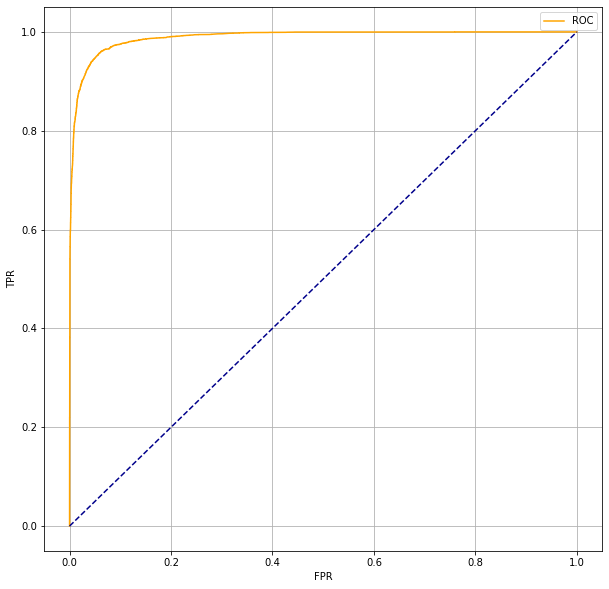

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, final_pred)
figure = plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0,1],[0,1], color='darkblue', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test,final_pred)


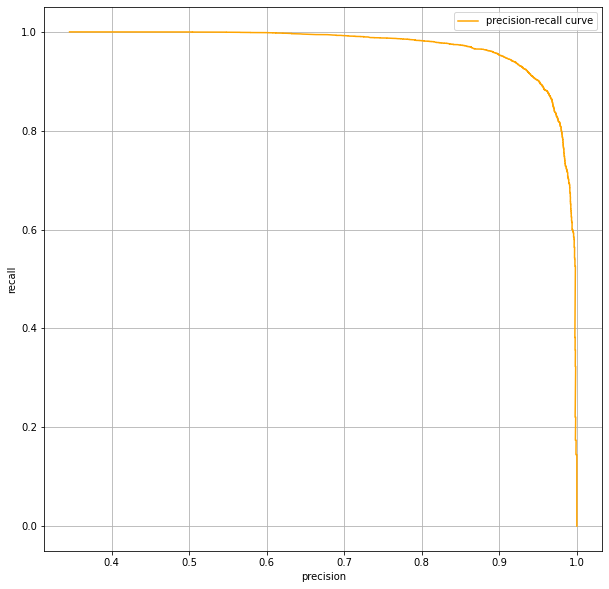

In [37]:
figure = plt.figure(figsize=(10,10))
plt.plot(precision, recall, color='orange', label='precision-recall curve')
#plt.plot([0,1],[0,1], color='darkblue', linestyle='--')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()
plt.grid()
plt.show()

## There is a steep fall in recall at 0.8 precision. We can select that threshold

In [38]:
thresholds

array([0.10781098, 0.10781703, 0.10782188, ..., 0.89120011, 0.89132946,
       0.89165808])

In [39]:
for i in precision:
    print(i)

0.34574168076706147
0.3457611822437814
0.3457806859205776
0.3458001917978225
0.3458196998758885
0.34583921015514807
0.34585872263597384
0.34587823731873835
0.34589775420381447
0.34591727329157496
0.3459367945823928
0.3459563180766409
0.3459758437746924
0.34599537167692046
0.34601490178369837
0.34603443409539936
0.34605396861239696
0.34607350533506465
0.34609304426377596
0.34611258539890466
0.3461321287408244
0.34615167428990906
0.34617122204653267
0.34619077201106907
0.34621032418389247
0.346229878565377
0.34624943515589696
0.3462689939558267
0.3462885549655406
0.34630811818541324
0.3463276836158192
0.34634725125713317
0.34636682110972994
0.3463863931739843
0.34640596745027125
0.3464255439389658
0.3464451226404431
0.3464647035550783
0.34648428668324666
0.3465038720253236
0.34652345958168457
0.3465430493527051
0.34656264133876075
0.34658223554022727
0.3466018319574805
0.34662143059089623
0.3466410314408505
0.3466606345077193
0.34668023979187873
0.3466998472937051
0.34671945701357465
0.3

0.40633700119315924
0.40636393768644347
0.4063908777512596
0.406417821388318
0.4064447685983291
0.4064717193820038
0.40649867374005305
0.4065256316731879
0.40655259318211967
0.40657955826755987
0.4066065269302202
0.4066334991708126
0.4066604749900491
0.40668745438864196
0.4067144373673036
0.4067414239267467
0.40676841406768416
0.40679540779082884
0.4068224050968941
0.4068494059865932
0.4068764104606398
0.40690341851974776
0.40693043016463093
0.4069574453960034
0.40698446421457973
0.4070114866210743
0.4070385126162019
0.4070655422006773
0.4070925753752158
0.40711961214053266
0.4071466524973433
0.4071736964463633
0.40720074398830874
0.40722779512389556
0.40725484985384003
0.40728190817885856
0.40730897009966777
0.4073360356169845
0.40736310473152576
0.4073901774440088
0.40741725375515087
0.4074443336656697
0.4074714171762829
0.40749850428770856
0.4075255950006648
0.40755268931586996
0.40757978723404253
0.40760688875590134
0.4076339938821652
0.40766110261355326
0.4076882149507848
0.407715

0.49687880016214026
0.49691908545484026
0.496959377280467
0.4969996756406098
0.49703998053685833
0.49708029197080295
0.4971206099440344
0.4971609344581441
0.49720126551472377
0.4972416031153659
0.4972819472616633
0.4973222979552093
0.497362655197598
0.4974030189904236
0.4974433893352812
0.4974837662337662
0.49752414968747466
0.4975645396980029
0.49760493626694813
0.49764533939590777
0.4976857490864799
0.4977261653402631
0.4977665881588565
0.49780701754385964
0.4978474534968727
0.49788789601949635
0.4979283451133317
0.4979688007799805
0.4980092630210449
0.49804973183812773
0.4980902072328322
0.498130689206762
0.4981711777615216
0.49821167289871565
0.4982521746199496
0.49829268292682927
0.498333197820961
0.49837371930395186
0.49841424737740914
0.4984547820429408
0.49849532330215535
0.4985358711566618
0.49857642560806964
0.49865755430803027
0.4986981285598047
0.49873870941492393
0.498779296875
0.49881989094164564
0.49886049161647406
0.4989010989010989
0.4989417127971345
0.4989823333061955

0.7449268232689706
0.7450184501845019
0.7451100996432526
0.7452017716535433
0.7452934662236987
0.7453851833620477
0.745476923076923
0.7455686853766618
0.7456604702696048
0.7457522777640975
0.7458441078684891
0.745935960591133
0.7460278359403868
0.7462116545521744
0.7463955637707949
0.7463643086024155
0.7464563046961666
0.7464250493096647
0.7465170755763778
0.7466091245376079
0.7467011962017511
0.7467932905772077
0.7468854076723819
0.7469775474956822
0.7470697100555213
0.7475308641975309
0.7476231633535004
0.7477154853050136
0.7478078300605162
0.7479001976284585
0.7482698961937716
0.7483623779508095
0.7486399604352126
0.7487325336960554
0.7488251298540688
0.7490103908955963
0.7491030557961154
0.7491957436278149
0.749288454399208
0.7493811881188119
0.749473944795148
0.7495667244367418
0.7496595270521234
0.7497523526498266
0.74984520123839
0.7499380728263562
0.7500309674222718
0.7501238850346879
0.7502168256721596
0.7503097893432465
0.7506818745350855
0.7507749535027899
0.7508680555555556

0.9821391911311845
0.9821355236139631
0.982131854590265
0.9821245120197247
0.9821208384710234
0.9821171634121274
0.9821134868421053
0.9821098087600246
0.9821061291649527
0.9821024480559556
0.9820987654320987
0.982095081292447
0.9820913956360642
0.9820877084620135
0.9820840197693574
0.9820803295571575
0.9820766378244746
0.9820729445703689
0.9820692497938994
0.9820655534941249
0.9820618556701031
0.9820544554455446
0.9822570662265319
0.9822534048699959
0.9822497420020639
0.9822460776218002
0.9822424117282677
0.9822387443205287
0.9822350753976451
0.9822314049586777
0.9822277330026865
0.9822240595287309
0.9822203845358694
0.9822167080231596
0.9822130299896588
0.9822093504344228
0.9822056693565073
0.9822019867549668
0.9821983026288553
0.9821946169772257
0.9821909297991303
0.9821872410936205
0.982390718873006
0.982387070037298
0.9823724595603484
0.9823688031528729
0.9823651452282157
0.9823614857854327
0.9823578248235783
0.9823541623417065
0.9823504983388704
0.9823468328141225
0.98234316576651

0.9982993197278912
0.998298355076574
0.9982973893303064
0.9982964224872232
0.9982954545454545
0.9982944855031268
0.9982935153583617
0.9982925441092771
0.9982915717539863
0.9982905982905983
0.9982896237172177
0.9982886480319453
0.9982876712328768
0.9982866933181039
0.9982847341337907
0.9982837528604119
0.998282770463652
0.9982817869415808
0.9982808022922636
0.9982798165137615
0.9982788296041308
0.9982778415614236
0.9982768523836876
0.9982758620689656
0.9982748706152962
0.9982738780207134
0.998272884283247
0.9982718894009217
0.9982708933717579
0.9982698961937716
0.9982688978649741
0.9982678983833718
0.9982668977469671
0.9982648930017352
0.9982638888888888
0.998262883613202
0.9982618771726536
0.9982588508415554
0.9982578397212544
0.9982568274259151
0.9982558139534884
0.9982547993019197
0.9982537834691502
0.9982527664531159
0.9982517482517482
0.9982507288629737
0.9982497082847142
0.9982486865148862
0.9982476635514018
0.9982466393921683
0.9982456140350877
0.9982445874780573
0.99824355971896

In [40]:
def get_threshold_with_precision(precisions, thresholds, min_desired_precision):
    for index, precision in enumerate(precisions):
        if precision>=min_desired_precision:
            return thresholds[index]

In [41]:
get_threshold_with_precision(precision,thresholds,0.8)

0.22338532892341992

## We will use 0.225 as the threshold so that recall is high and False Negatives can be reduced

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
rf = RandomForestClassifier()

In [44]:
rf.fit(X_train,y_train)

RandomForestClassifier()

#### Clearly False Negatives are quite less

### With 0.5 as threshold

In [45]:
predictions = rf.predict(X_test)

In [46]:
confusion_matrix(y_test,predictions)

array([[11172,   428],
       [  392,  5738]], dtype=int64)

### With custom threshold

In [47]:
probalities = rf.predict_proba(X_test)[:,1]

In [48]:
predictions = np.where(probalities>0.225,1,0)

In [49]:
confusion_matrix(y_test,predictions)

array([[10744,   856],
       [  184,  5946]], dtype=int64)

### Here: 

1. TN: 10746
2. TP: 5944
3. FP: 854
4. FN: 186

## Clearly with this threshold, we have reduced the False Negatives

In [50]:
custom_threshold = 0.225

# Testing Different models

#### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lr = LogisticRegression(max_iter=10000)

In [53]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [54]:
predictions = lr.predict_proba(X_test)[:,1]

In [55]:
predictions = np.where(predictions>custom_threshold,1,0)

In [56]:
confusion_matrix(y_test,predictions)

array([[10131,  1469],
       [  228,  5902]], dtype=int64)

In [57]:
roc_auc_score(y_test,predictions)

0.9180839708612253

In [58]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     11600
           1       0.80      0.96      0.87      6130

    accuracy                           0.90     17730
   macro avg       0.89      0.92      0.90     17730
weighted avg       0.92      0.90      0.91     17730



#### KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
knn = KNeighborsClassifier()

In [61]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [62]:
predictions = knn.predict_proba(X_test)[:,1]

In [63]:
predictions = np.where(predictions>custom_threshold,1,0)

In [64]:
confusion_matrix(y_test,predictions)

array([[10875,   725],
       [  330,  5800]], dtype=int64)

In [65]:
roc_auc_score(y_test,predictions)

0.9418331973898858

In [66]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11600
           1       0.89      0.95      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.94      0.94     17730
weighted avg       0.94      0.94      0.94     17730



#### Random Forest

In [67]:
rf = RandomForestClassifier()

In [68]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [69]:
predictions = rf.predict_proba(X_test)[:,1]

In [70]:
predictions = np.where(predictions>custom_threshold,1,0)

In [71]:
confusion_matrix(y_test,predictions)

array([[10745,   855],
       [  184,  5946]], dtype=int64)

In [72]:
roc_auc_score(y_test,predictions)

0.9481383951172863

In [73]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11600
           1       0.87      0.97      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.95      0.94     17730
weighted avg       0.95      0.94      0.94     17730



#### Extra Trees Classifier

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
extra = ExtraTreesClassifier()

In [76]:
extra.fit(X_train,y_train)

ExtraTreesClassifier()

In [77]:
predictions = extra.predict_proba(X_test)[:,1]

In [78]:
predictions = np.where(predictions>custom_threshold,1,0)

In [79]:
confusion_matrix(y_test,predictions)

array([[10746,   854],
       [  202,  5928]], dtype=int64)

In [80]:
roc_auc_score(y_test,predictions)

0.9467133093322834

In [81]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11600
           1       0.87      0.97      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.95      0.94     17730
weighted avg       0.94      0.94      0.94     17730



#### Ada Boost

In [82]:
from sklearn.ensemble import AdaBoostClassifier

In [83]:
ada = AdaBoostClassifier()

In [84]:
ada.fit(X_train,y_train)

AdaBoostClassifier()

In [85]:
predictions = ada.predict_proba(X_test)[:,1]

In [86]:
predictions = np.where(predictions>custom_threshold,1,0)

In [87]:
confusion_matrix(y_test,predictions)

array([[    0, 11600],
       [    0,  6130]], dtype=int64)

In [88]:
roc_auc_score(y_test,predictions)

0.5

In [89]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11600
           1       0.35      1.00      0.51      6130

    accuracy                           0.35     17730
   macro avg       0.17      0.50      0.26     17730
weighted avg       0.12      0.35      0.18     17730



C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Gradient Boost

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

In [91]:
gradient_clf = GradientBoostingClassifier()

In [92]:
gradient_clf.fit(X_train,y_train)

GradientBoostingClassifier()

In [93]:
predictions = gradient_clf.predict_proba(X_test)[:,1]

In [94]:
predictions = np.where(predictions>custom_threshold,1,0)

In [95]:
confusion_matrix(y_test,predictions)

array([[10388,  1212],
       [  165,  5965]], dtype=int64)

In [96]:
roc_auc_score(y_test,predictions)

0.934300219384598

In [97]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     11600
           1       0.83      0.97      0.90      6130

    accuracy                           0.92     17730
   macro avg       0.91      0.93      0.92     17730
weighted avg       0.93      0.92      0.92     17730

